In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import os
from uncertainties import ufloat
from scipy.optimize import curve_fit

In [2]:
sizes = pd.read_csv('/Users/js/school/phy224/fluid/sizes.csv')
sizes['radius'] = sizes.diameter / 2

In [61]:
fluid = 'water' #either 'water' or 'glycerine'

maindir = f'/Users/js/school/phy224/fluid/drops/{fluid}'

In [62]:
def get_colours(palette, n):
    clrs = []
    cmap = matplotlib.cm.get_cmap(palette, n)
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        clrs.append(matplotlib.colors.rgb2hex(rgb))
    return clrs

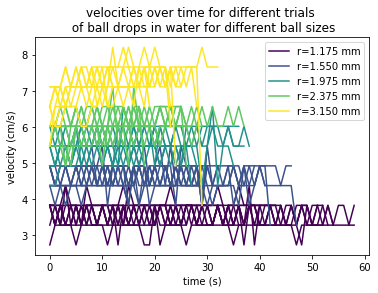

In [64]:
n = len(os.listdir(maindir))
cols = get_colours('viridis', n)
allmeans = [0] * n # mean velocities for each ball size
for size in sorted(os.listdir(maindir)):
    meanvels = [] # mean velocity over all trial drops for a ball of a given size
    for dropnum in os.listdir(f'{maindir}/{size}'): # loop over each trial
        if dropnum.endswith('.txt'):
            time, pos = np.loadtxt(f'{maindir}/{size}/{dropnum}', unpack=True, skiprows=2)
            time = np.array([ufloat(i, 0.0005) for i in time.tolist()])
            pos = np.array([ufloat(j, 0.002) for j in pos.tolist()])
            condition = pos > 1e-6
            time, pos = time[condition], pos[condition]
            vel = np.diff(pos)
#             plt.plot([k.nominal_value for k in vel]) # include this plot, explain why chop off first couple. 
            vel = vel[8:]
            plt.plot([k.nominal_value for k in vel], c=cols[int(size)-1])
            plt.xlabel('time (s)')
            plt.ylabel('velocity (cm/s)')
            plt.title(f'velocities over time for different trials \n of ball drops in {fluid} for different ball sizes')
            meanvels.append(vel.mean())
    plt.plot([],[], c=cols[int(size)-1], label=f'r={sizes[sizes.fluid == fluid].radius.values[(int(size)-1)]:.3f} mm')
    plt.legend()
    meanvels = np.array(meanvels)
    allmeans[int(size)-1] = meanvels.mean()
plt.savefig(f'{fluid}.png')

In [76]:
for j in allmeans:
    print(j)

3.594577+/-0.000018
4.622179+/-0.000024
5.516259+/-0.000031
6.07499+/-0.00004
7.17553+/-0.00004


In [66]:
def wallcorr(v, d, D):
    return v / (1 - 2.104*(d/D) + 2.089*(d/D)**2)

In [67]:
corrvels = [(wallcorr(v/100, d/1000, 0.095) * 100) for d, v in zip(sizes[sizes.fluid == fluid].diameter, allmeans)]
for j in corrvels:
    print(j)

3.786826+/-0.000019
4.951092+/-0.000026
6.021267+/-0.000033
6.74982+/-0.00004
8.25097+/-0.00004


In [68]:
def reynolds(rho, v, l, eta):
    return (rho * v * l) / eta

In [69]:
dens = 1.26 if fluid == 'glycerine' else 1.
visc = 9.34 if fluid == 'glycerine' else 0.01

reys = [(reynolds(dens, v, d/10, visc)) for d, v in zip(sizes[sizes.fluid == fluid].diameter, corrvels)]
for r in reys:
    print(r)

88.9904+/-0.0005
153.4839+/-0.0008
237.8400+/-0.0013
320.6167+/-0.0019
519.8110+/-0.0028


In [70]:
def model(x, a, b):
    return a * x**b

def model1(x, a):
    return a * x**2

def model2(x, a):
    return a * x**0.5

In [73]:
popt, pcov = curve_fit(f=model, xdata=sizes[sizes.fluid == fluid].radius, ydata=[i.nominal_value for i in corrvels], sigma=[j.std_dev for j in corrvels], absolute_sigma=True)
popt2, pcov2 = curve_fit(f=model2, xdata=sizes[sizes.fluid == fluid].radius, ydata=[i.nominal_value for i in corrvels], sigma=[j.std_dev for j in corrvels], absolute_sigma=True)
print(popt)
print(popt2)

[3.42601669 0.78379022]
[4.04422595]


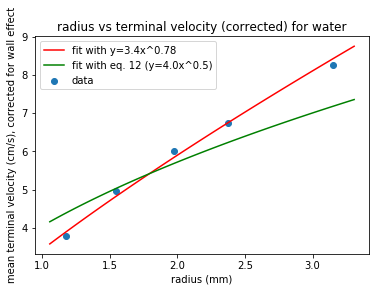

In [75]:
xdat = np.linspace(min(sizes[sizes.fluid == fluid].radius)*0.9, max(sizes[sizes.fluid == fluid].radius)*1.05)
plt.scatter(sizes[sizes.fluid == fluid].radius, [i.nominal_value for i in corrvels], label='data')
plt.plot(xdat, model(xdat, *popt), c='r', label=f'fit with y={popt[0]:.1f}x^{popt[1]:.2f}')
plt.plot(xdat, model2(xdat, *popt2), c='g', label=f'fit with eq. 12 (y={popt2[0]:.1f}x^0.5)')
plt.xlabel('radius (mm)')
plt.ylabel('mean terminal velocity (cm/s), corrected for wall effect')
plt.title(f'radius vs terminal velocity (corrected) for {fluid}')
plt.legend();


In [52]:
def rcs(pred, target, uncertainty, n_params):
    return np.square((pred - target) / uncertainty).sum() / (pred.size - n_params)

In [58]:
rcs(model1(sizes[sizes.fluid == fluid].radius, *popt2), [i.nominal_value for i in corrvels], [j.std_dev for j in corrvels], 1)

46084913.189762056